# 一、导入数据

In [78]:
from torchvision import datasets

In [79]:
# train_data = datasets.MNIST(root = "F:/MLdata/", train=True, download=False)
train_data = datasets.MNIST(root = "Users/tian/Downloads/", train=True, download=True)

In [5]:
# import torch, os
# train_data = torch.load(os.path.join("Users/tian/Downloads/", "sample_data.pth"), map_location='cpu')

In [80]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: Users/tian/Downloads/
    Split: Train

# 二、实现K-Means聚类算法

## （一）算法细节处理设计
### 1、特征向量表示图片

In [142]:
import numpy as np
def convert(vector):
    image, label = vector
    # 将PIL图像转换为灰度值矩阵
    gray_image = np.array(image)

    # 展平图像矩阵
    flat_image = gray_image.reshape(-1)

    # 归一化处理
    normalized_image = flat_image / 255.0

    return normalized_image, label

In [143]:
vectors, labels = [], []
for vector in train_data:
    a, b = convert(vector)
    vectors.append(a)
    labels.append(b)

In [9]:
np.random.seed(42)

### 2、聚类数量确定

- 肘部法则

In [102]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

In [12]:
X = vectors
# 对数据进行降维，以加快聚类算法的速度
pca = PCA(n_components=50)  # 选择一个合适的维度
X_pca = pca.fit_transform(X)

In [12]:
from tqdm import tqdm

# 使用K-means算法
k_values = range(1, 50)  # 选择一系列可能的聚类数量
inertia_values = []

for k in tqdm(k_values, desc='Clustering Progress'):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)


Clustering Progress: 100%|██████████| 49/49 [05:00<00:00,  6.14s/it]


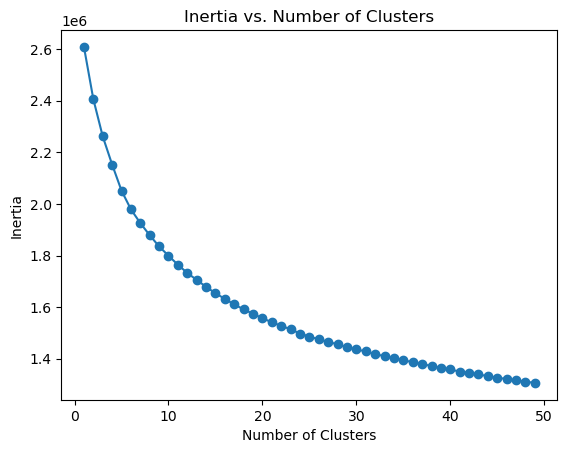

In [15]:
# 绘制惯性曲线，以帮助确定最佳聚类数量
import matplotlib.pyplot as plt

plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')
plt.show()

In [ ]:
# 可能大概选15

- 实际的分类情况

### 3、聚类中心初始化

In [134]:
import numpy as np

def kmeans_pp_init(features, k):
    # 从特征向量中随机选择一个作为第一个聚类中心
    centers = [features[np.random.choice(len(features))]]
    
    # 选择后续聚类中心
    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(c - x) for c in centers]) for x in features])
        probabilities = distances / distances.sum()
        next_center_index = np.random.choice(len(features), p=probabilities)
        centers.append(features[next_center_index])
    
    return np.array(centers)


In [135]:
# 示例用法
k = 15
initial_centers = kmeans_pp_init(vectors, k)
print("初始化的聚类中心：", initial_centers)

初始化的聚类中心： [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
len(initial_centers[0])

784

### 4、如何衡量样本距离

In [136]:
# 应该就是使用欧氏距离

### 5、如何设置终止条件

In [157]:
from tqdm import tqdm

class KMeans:
    def __init__(self, n_clusters, controids, max_iter=100, tol=1e-4):
        # 初始化方法，用于设定 KMeans 类的参数
        self.n_clusters = n_clusters  # 簇的数量
    
        self.max_iter = max_iter  # 最大迭代次数
        self.tol = tol  # 收敛容忍度
        self.controids = controids
        self.distances = []

    def fit(self, X):
        # 拟合方法，用于训练 KMeans 模型
        # 初始化之心
        centroids = np.stack(self.controids)
        
        # 初始化迭代过程的变量
        prev_centroids = None  
        prev_labels = None 
        prev_inertia = None 
        no_change_iters = 0  
        
        for _ in tqdm(range(self.max_iter)):  # 在这里添加 tqdm
            # 将每个数据点分配到最近的质心
            labels = self._assign_labels(X, centroids)
            
            # 更新质心
            centroids = self._update_centroids(X, labels)
            
            # 计算整体距离（数据点到质心的平方距离之和）
            inertia = self._compute_inertia(X, centroids, labels)
            
            # 检查收敛条件
            if (prev_inertia is not None and abs(inertia - prev_inertia) < self.tol) or no_change_iters >= 5:
                break  # 如果整体距离变化不显著或连续5次没有变化，则停止迭代
            
            if prev_centroids is not None and np.allclose(centroids, prev_centroids, atol=self.tol):
                no_change_iters += 1
            else:
                no_change_iters = 0
            
            # 报告这一轮的结果
            print(f"整体欧氏距离为{inertia}")

            # 更新下一轮迭代的先前值
            prev_centroids = centroids.copy()
            prev_labels = labels.copy()
            prev_inertia = inertia
        
        # 将结果存储在对象属性中
        self.labels_ = prev_labels  # 簇标签
        self.cluster_centers_ = prev_centroids  # 质心
        self.inertia_ = prev_inertia  # 整体距离
        self.distances.append(prev_inertia)
        return self  # 返回自身
    
    def _assign_labels(self, X, centroids):
        # 辅助方法：将数据点分配到最近的质心
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X, labels):
        # 辅助方法：更新质心位置
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            centroids[i] = np.mean(X[labels == i], axis=0)
        return centroids
    
    def _compute_inertia(self, X, centroids, labels):
        # 辅助方法：计算惯性
        distances = np.linalg.norm(X - centroids[labels], axis=1)
        return np.sum(distances ** 2)


In [20]:
# 初始化并拟合 KMeans 模型，设置终止条件
kmeans = KMeans(n_clusters=15, controids=initial_centers)
kmeans.fit(np.vstack(vectors))

# 打印簇中心和惯性
print("Cluster Centers:")  # 簇中心
print(kmeans.cluster_centers_)  # 打印质心
print("Inertia:", kmeans.inertia_)  # 打印惯性

  1%|          | 1/100 [00:05<09:38,  5.84s/it]

整体欧氏距离为2506628.5552648874


  2%|▏         | 2/100 [00:59<55:26, 33.94s/it]

整体欧氏距离为2355219.2825405407


  3%|▎         | 3/100 [02:00<1:14:43, 46.22s/it]

整体欧氏距离为2294715.2675737967


  4%|▍         | 4/100 [02:51<1:17:13, 48.27s/it]

整体欧氏距离为2261549.436793651


  5%|▌         | 5/100 [03:41<1:17:29, 48.95s/it]

整体欧氏距离为2248732.638794489


  6%|▌         | 6/100 [04:27<1:15:10, 47.99s/it]

整体欧氏距离为2242855.455340214


  7%|▋         | 7/100 [05:16<1:14:41, 48.19s/it]

整体欧氏距离为2239008.795675061


  8%|▊         | 8/100 [06:10<1:16:39, 50.00s/it]

整体欧氏距离为2235855.8181482605


  9%|▉         | 9/100 [07:00<1:15:45, 49.96s/it]

整体欧氏距离为2233122.924226637


 10%|█         | 10/100 [07:49<1:14:37, 49.75s/it]

整体欧氏距离为2230744.926174856


 11%|█         | 11/100 [08:43<1:15:31, 50.92s/it]

整体欧氏距离为2228713.504234148


 12%|█▏        | 12/100 [09:31<1:13:30, 50.11s/it]

整体欧氏距离为2227097.1879308857


 13%|█▎        | 13/100 [25:38<7:55:23, 327.86s/it]

整体欧氏距离为2225867.3236670126


 14%|█▍        | 14/100 [2:11:27<51:16:51, 2146.64s/it]

整体欧氏距离为2224833.5420728517


 15%|█▌        | 15/100 [2:29:05<42:56:17, 1818.56s/it]

整体欧氏距离为2223901.1113467626


 16%|█▌        | 16/100 [2:30:04<30:04:22, 1288.84s/it]

整体欧氏距离为2222965.719885064


 17%|█▋        | 17/100 [2:31:00<21:10:05, 918.13s/it] 

整体欧氏距离为2222131.073502097


 18%|█▊        | 18/100 [2:31:53<14:59:26, 658.13s/it]

整体欧氏距离为2221455.572742419


 19%|█▉        | 19/100 [2:32:41<10:41:10, 474.94s/it]

整体欧氏距离为2220904.105730318


 20%|██        | 20/100 [2:50:21<14:27:32, 650.66s/it]

整体欧氏距离为2220326.6358016715


 21%|██        | 21/100 [2:51:20<10:22:29, 472.78s/it]

整体欧氏距离为2219739.76622322


 22%|██▏       | 22/100 [2:52:22<7:34:36, 349.70s/it] 

整体欧氏距离为2219045.0954911825


 23%|██▎       | 23/100 [2:53:18<5:35:36, 261.52s/it]

整体欧氏距离为2218186.0308073894


 24%|██▍       | 24/100 [2:54:11<4:11:58, 198.92s/it]

整体欧氏距离为2217170.7667376087


 25%|██▌       | 25/100 [2:55:10<3:16:18, 157.05s/it]

整体欧氏距离为2216084.7898551677


 26%|██▌       | 26/100 [2:56:00<2:33:54, 124.79s/it]

整体欧氏距离为2214980.6958862296


 27%|██▋       | 27/100 [2:56:53<2:05:39, 103.28s/it]

整体欧氏距离为2213871.9699469656


 28%|██▊       | 28/100 [2:57:46<1:45:42, 88.09s/it] 

整体欧氏距离为2212953.0112314806


 29%|██▉       | 29/100 [2:58:46<1:34:21, 79.74s/it]

整体欧氏距离为2212319.688672644


 30%|███       | 30/100 [2:59:41<1:24:33, 72.47s/it]

整体欧氏距离为2211939.1990663046


 31%|███       | 31/100 [3:00:29<1:14:48, 65.05s/it]

整体欧氏距离为2211699.6026026993


 32%|███▏      | 32/100 [3:01:25<1:10:46, 62.45s/it]

整体欧氏距离为2211549.8188921884


 33%|███▎      | 33/100 [3:02:18<1:06:28, 59.52s/it]

整体欧氏距离为2211429.599371081


 34%|███▍      | 34/100 [3:03:09<1:02:36, 56.92s/it]

整体欧氏距离为2211333.2573886006


 35%|███▌      | 35/100 [3:03:56<58:33, 54.05s/it]  

整体欧氏距离为2211234.690049199


 36%|███▌      | 36/100 [3:04:53<58:32, 54.89s/it]

整体欧氏距离为2211148.2361268834


 37%|███▋      | 37/100 [3:05:55<59:52, 57.02s/it]

整体欧氏距离为2211080.917375791


 38%|███▊      | 38/100 [3:06:54<59:31, 57.60s/it]

整体欧氏距离为2211023.6778257634


 39%|███▉      | 39/100 [3:07:56<59:54, 58.92s/it]

整体欧氏距离为2210983.032385245


 40%|████      | 40/100 [3:08:54<58:30, 58.50s/it]

整体欧氏距离为2210948.142745783


 41%|████      | 41/100 [3:09:49<56:26, 57.40s/it]

整体欧氏距离为2210917.300368794


 42%|████▏     | 42/100 [3:10:42<54:12, 56.08s/it]

整体欧氏距离为2210888.019643075


 43%|████▎     | 43/100 [3:11:39<53:46, 56.60s/it]

整体欧氏距离为2210867.03948532


 44%|████▍     | 44/100 [3:12:32<51:38, 55.33s/it]

整体欧氏距离为2210850.0447055576


 45%|████▌     | 45/100 [3:13:19<48:24, 52.80s/it]

整体欧氏距离为2210833.1094968882


 46%|████▌     | 46/100 [3:14:09<46:59, 52.21s/it]

整体欧氏距离为2210816.731440034


 47%|████▋     | 47/100 [3:14:59<45:29, 51.50s/it]

整体欧氏距离为2210803.348559367


 48%|████▊     | 48/100 [3:15:49<44:12, 51.02s/it]

整体欧氏距离为2210789.6899417723


 49%|████▉     | 49/100 [3:16:38<42:45, 50.30s/it]

整体欧氏距离为2210776.2768970462


 50%|█████     | 50/100 [3:17:23<40:42, 48.85s/it]

整体欧氏距离为2210766.1117896773


 51%|█████     | 51/100 [3:18:15<40:40, 49.81s/it]

整体欧氏距离为2210757.1216443167


 52%|█████▏    | 52/100 [3:19:09<40:49, 51.04s/it]

整体欧氏距离为2210748.2538144123


 53%|█████▎    | 53/100 [3:20:03<40:30, 51.72s/it]

整体欧氏距离为2210739.488226254


 54%|█████▍    | 54/100 [3:20:59<40:43, 53.12s/it]

整体欧氏距离为2210732.8956895103


 55%|█████▌    | 55/100 [3:21:58<41:14, 55.00s/it]

整体欧氏距离为2210726.3589448947


 56%|█████▌    | 56/100 [3:22:48<39:13, 53.49s/it]

整体欧氏距离为2210721.454780087


 57%|█████▋    | 57/100 [3:23:35<36:56, 51.55s/it]

整体欧氏距离为2210714.9678423037


 58%|█████▊    | 58/100 [3:24:25<35:41, 51.00s/it]

整体欧氏距离为2210710.5946453675


 59%|█████▉    | 59/100 [3:25:14<34:31, 50.53s/it]

整体欧氏距离为2210707.8905044296


 60%|██████    | 60/100 [3:26:06<33:54, 50.86s/it]

整体欧氏距离为2210705.3090043897


 61%|██████    | 61/100 [3:26:58<33:21, 51.32s/it]

整体欧氏距离为2210703.490120849


 62%|██████▏   | 62/100 [3:27:58<34:05, 53.83s/it]

整体欧氏距离为2210701.058778237


 63%|██████▎   | 63/100 [3:28:46<32:04, 52.01s/it]

整体欧氏距离为2210697.62525753


 64%|██████▍   | 64/100 [3:29:45<32:26, 54.07s/it]

整体欧氏距离为2210695.126991139


 65%|██████▌   | 65/100 [3:30:45<32:37, 55.93s/it]

整体欧氏距离为2210692.791117915


 66%|██████▌   | 66/100 [3:31:40<31:33, 55.70s/it]

整体欧氏距离为2210690.178309649


 67%|██████▋   | 67/100 [3:32:43<31:46, 57.76s/it]

整体欧氏距离为2210688.874779995


 68%|██████▊   | 68/100 [3:33:43<31:07, 58.35s/it]

整体欧氏距离为2210688.020371


 69%|██████▉   | 69/100 [3:34:36<29:25, 56.94s/it]

整体欧氏距离为2210687.3648451613


 70%|███████   | 70/100 [3:35:29<27:52, 55.75s/it]

整体欧氏距离为2210687.172154776


 71%|███████   | 71/100 [3:36:24<26:46, 55.39s/it]

整体欧氏距离为2210686.8931455393


 72%|███████▏  | 72/100 [3:37:17<25:35, 54.84s/it]

整体欧氏距离为2210686.4728325442


 73%|███████▎  | 73/100 [3:38:15<25:02, 55.64s/it]

整体欧氏距离为2210686.1628432325


 74%|███████▍  | 74/100 [3:39:08<23:47, 54.89s/it]

整体欧氏距离为2210685.8162743794


 75%|███████▌  | 75/100 [3:39:55<21:53, 52.54s/it]

整体欧氏距离为2210685.5282293246


 76%|███████▌  | 76/100 [3:40:44<20:35, 51.48s/it]

整体欧氏距离为2210685.145158918


 77%|███████▋  | 77/100 [3:41:41<20:22, 53.17s/it]

整体欧氏距离为2210684.7760033207


 78%|███████▊  | 78/100 [3:42:41<20:11, 55.05s/it]

整体欧氏距离为2210684.371595768


 79%|███████▉  | 79/100 [3:43:39<19:40, 56.21s/it]

整体欧氏距离为2210684.0904712924


 80%|████████  | 80/100 [3:44:38<18:59, 56.99s/it]

整体欧氏距离为2210683.839484183


 81%|████████  | 81/100 [3:45:27<17:17, 54.61s/it]

整体欧氏距离为2210683.5736892372


 82%|████████▏ | 82/100 [3:46:21<16:16, 54.25s/it]

整体欧氏距离为2210683.2061860263


 83%|████████▎ | 83/100 [3:47:08<14:48, 52.29s/it]

整体欧氏距离为2210683.0671330495


 84%|████████▍ | 84/100 [3:48:10<14:40, 55.05s/it]

整体欧氏距离为2210682.952542388


 85%|████████▌ | 85/100 [3:49:02<13:33, 54.24s/it]

整体欧氏距离为2210682.89825873


 86%|████████▌ | 86/100 [3:49:58<12:46, 54.77s/it]

整体欧氏距离为2210682.8644878664


 86%|████████▌ | 86/100 [3:50:56<37:35, 161.12s/it]

Cluster Centers:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Inertia: 2210682.8644878664


In [29]:
import pickle

def save_variable(variable, filename):
    with open(filename, 'wb') as f:
        pickle.dump(variable, f)

def load_variable(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# 保存变量到文件
save_variable(kmeans, './data.pkl')


In [30]:
# 从文件中加载变量
kmeans = load_variable('./data.pkl')

In [31]:
len(kmeans.labels_)

60000

In [27]:
kmeans.labels_[0]

14

In [28]:
from collections import Counter


# 每个聚类中的样本统计标签
cluster_labels = [[] for _ in range(15)]
for i, label in enumerate(kmeans.labels_):  # 假设你的聚类结果存储在kmeans.labels_中
    cluster_labels[label].append(labels[i])

# 多数投票确定标签
final_cluster_labels = []
for labels in cluster_labels:
    if len(labels) > 0:
        most_common_label = Counter(labels).most_common(1)[0][0]
        final_cluster_labels.append(most_common_label)
    else:
        # 处理没有样本的聚类
        final_cluster_labels.append(None)

# 设置阈值
threshold = 5  
for i, labels in enumerate(cluster_labels):
    if len(labels) > 0:
        counts = Counter(labels)
        if counts.most_common(1)[0][1] >= threshold:
            final_cluster_labels[i] = counts.most_common(1)[0][0]

# 最终的聚类标签
print(final_cluster_labels)

[2, 9, 0, 7, 4, 3, 0, 6, 1, 7, 1, 4, 8, 6, 3]


# 三、评价模型表现

## （一）定量评价

In [33]:
final_cluster_labels

[2, 9, 0, 7, 4, 3, 0, 6, 1, 7, 1, 4, 8, 6, 3]

In [37]:
predict_labels = [final_cluster_labels[i] for i in kmeans.labels_]

In [40]:
len(labels)

4453

In [130]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np


# 计算准确率
accuracy = accuracy_score(labels, predict_labels)
print("Accuracy:", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(labels, predict_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, range(1, len(conf_matrix) + 1))
plt.yticks(tick_marks, range(1, len(conf_matrix) + 1))

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")

plt.show()

# 计算精确率和召回率
precision = precision_score(labels, predict_labels, average='macro')
recall = recall_score(labels, predict_labels, average='macro')
print("Precision:", precision)
print("Recall:", recall)


ValueError: Found input variables with inconsistent numbers of samples: [60000, 2000]

## （二）定性评价

In [55]:
kmeans.labels_ # 每一个特征向量对应的聚类，总共60000个
kmeans.cluster_centers_ # 每一个聚类的聚类中心的位置，总共15个
kmeans.inertia_ # 最终的整体距离
kmeans.distances # 每一次迭代后的整体距离的list

60000

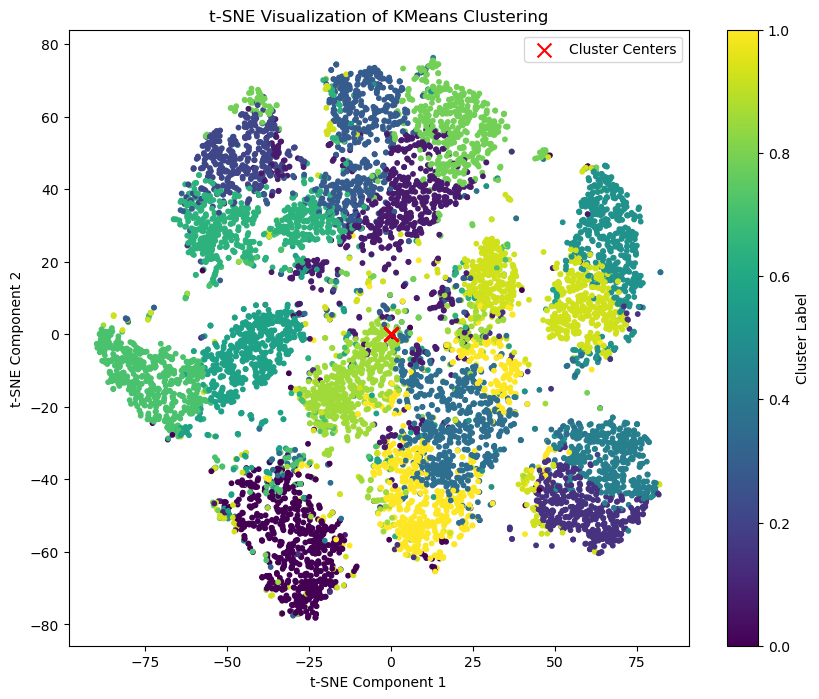

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

# 获取聚类标签和聚类中心
labels = kmeans.labels_[:10000]
centers = kmeans.cluster_centers_[:10000]

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.vstack(vectors[:10000]))

# 可视化聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.title('t-SNE Visualization of KMeans Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()


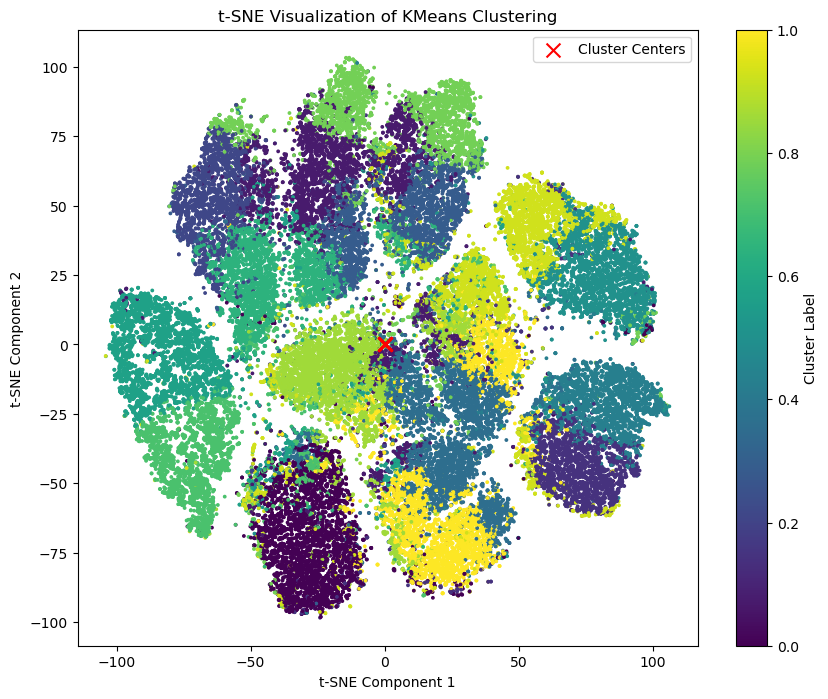

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

# 获取聚类标签和聚类中心
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.vstack(vectors))

# 可视化聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=3)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.title('t-SNE Visualization of KMeans Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()


In [75]:
distances = [
    2506628.5552648874,
    2355219.2825405407,
    2294715.2675737967,
    2261549.436793651,
    2248732.638794489,
    2242855.455340214,
    2239008.795675061,
    2235855.8181482605,
    2233122.924226637,
    2230744.926174856,
    2228713.504234148,
    2227097.1879308857,
    2225867.3236670126,
    2224833.5420728517,
    2223901.1113467626,
    2222965.719885064,
    2222131.073502097,
    2221455.572742419,
    2220904.105730318,
    2220326.6358016715,
    2219739.76622322,
    2219045.0954911825,
    2218186.0308073894,
    2217170.7667376087,
    2216084.7898551677,
    2214980.6958862296,
    2213871.9699469656,
    2212953.0112314806,
    2212319.688672644,
    2211939.1990663046,
    2211699.6026026993,
    2211549.8188921884,
    2211429.599371081,
    2211333.2573886006,
    2211234.690049199,
    2211148.2361268834,
    2211080.917375791,
    2211023.6778257634,
    2210983.032385245,
    2210948.142745783,
    2210917.300368794,
    2210888.019643075,
    2210867.03948532,
    2210850.0447055576,
    2210833.1094968882,
    2210816.731440034,
    2210803.348559367,
    2210789.6899417723,
    2210776.2768970462,
    2210766.1117896773,
    2210757.1216443167,
    2210748.2538144123,
    2210739.488226254,
    2210732.8956895103,
    2210726.3589448947,
    2210714.9678423037,
    2210710.5946453675,
    2210707.8905044296,
    2210705.3090043897,
    2210703.490120849,
    2210701.058778237,
    2210697.62525753,
    2210695.126991139,
    2210692.791117915,
    2210690.178309649,
    2210688.874779995,
    2210688.020371,
    2210687.3648451613,
    2210687.172154776,
    2210686.8931455393,
    2210686.4728325442,
    2210686.1628432325,
    2210685.8162743794,
    2210685.5282293246,
    2210685.145158918,
    2210684.7760033207,
    2210684.371595768,
    2210684.0904712924,
    2210683.839484183,
    2210683.5736892372,
    2210683.2061860263,
    2210683.0671330495,
    2210682.952542388,
    2210682.89825873,
    2210682.8644878664
]


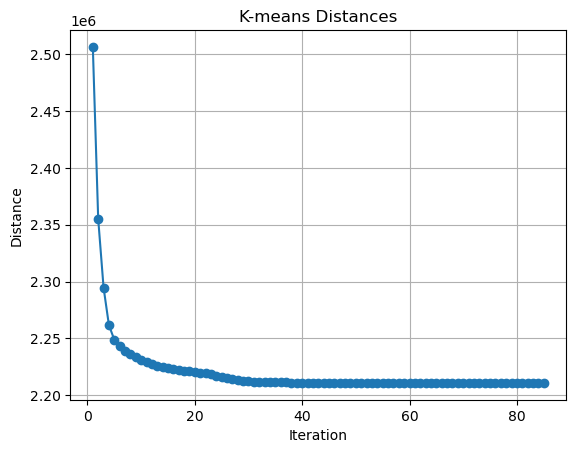

In [76]:
import matplotlib.pyplot as plt


# 生成 x 轴的值，假设为 1 到列表长度
x_values = list(range(1, len(distances) + 1))

# 绘制折线图
plt.plot(x_values, distances, marker='o', linestyle='-')

# 添加标题和标签
plt.title('K-means Distances')
plt.xlabel('Iteration')
plt.ylabel('Distance')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()


In [72]:
from sklearn.metrics import silhouette_samples

# 计算每个样本的轮廓系数
silhouette_vals = silhouette_samples(np.stack(vectors), kmeans.labels_)

# 计算所有样本的平均轮廓系数
silhouette_avg = silhouette_vals.mean()

print("平均轮廓系数:", silhouette_avg)


平均轮廓系数: 0.06065782194594797


# 四、实验分析

## （一）不同K的取值的影响

In [125]:
# 减少整体数据量 弄个k=25的
vectors, labels = [], []
for vector in train_data:
    a, b = convert(vector)
    vectors.append(a)
    labels.append(b)

In [126]:
# 对比的结果
k = 15
initial_centers = kmeans_pp_init(vectors[:2000], k)

In [127]:
# 初始化并拟合 KMeans 模型，设置终止条件
kmeans = KMeans(n_clusters=15, controids=initial_centers)
kmeans.fit(np.vstack(vectors[:2000]))

TypeError: KMeans.__init__() got an unexpected keyword argument 'controids'

In [87]:
from collections import Counter


# 每个聚类中的样本统计标签
cluster_labels = [[] for _ in range(15)]
for i, label in enumerate(kmeans.labels_):  # 假设你的聚类结果存储在kmeans.labels_中
    cluster_labels[label].append(labels[i])

# 多数投票确定标签
final_cluster_labels = []
for labels in cluster_labels:
    if len(labels) > 0:
        most_common_label = Counter(labels).most_common(1)[0][0]
        final_cluster_labels.append(most_common_label)
    else:
        # 处理没有样本的聚类
        final_cluster_labels.append(None)

# 设置阈值
threshold = 5  
for i, labels in enumerate(cluster_labels):
    if len(labels) > 0:
        counts = Counter(labels)
        if counts.most_common(1)[0][1] >= threshold:
            final_cluster_labels[i] = counts.most_common(1)[0][0]

# 最终的聚类标签
print(final_cluster_labels)

[6, 2, 5, 9, 3, 9, 1, 8, 1, 8, 7, 0, 0, 4, 3]


In [88]:
predict_labels = [final_cluster_labels[i] for i in kmeans.labels_]

Accuracy: 0.6505
Confusion Matrix:
[[165   1   0   6   1   9   3   0   5   1]
 [  0 214   0   1   0   1   0   0   4   0]
 [  1  43 108  11   7  12   7   4   3   2]
 [  1  14   2 139   2   7   1   1  20   4]
 [  0  11   2   0  97   3   3   1   3  94]
 [  5   1   1  70   3  68   3   0  22   7]
 [  4  14   1   1  24  13 143   0   0   0]
 [  0  19   0   1  18   3   0 107   2  74]
 [  0  11   0  29   0   4   1   1 120   6]
 [  2   4   0   8  44   0   1   4   7 140]]


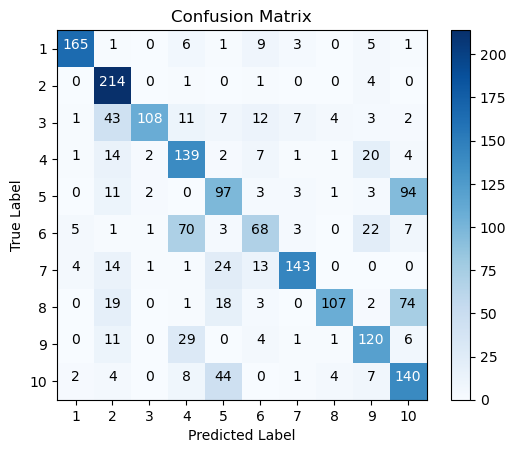

Precision: 0.6964520312283188
Recall: 0.6497873317346083


In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
labels = labels[:2000]

# 计算准确率
accuracy = accuracy_score(labels, predict_labels)
print("Accuracy:", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(labels, predict_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, range(1, len(conf_matrix) + 1))
plt.yticks(tick_marks, range(1, len(conf_matrix) + 1))

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")

plt.show()

# 计算精确率和召回率
precision = precision_score(labels, predict_labels, average='macro')
recall = recall_score(labels, predict_labels, average='macro')
print("Precision:", precision)
print("Recall:", recall)


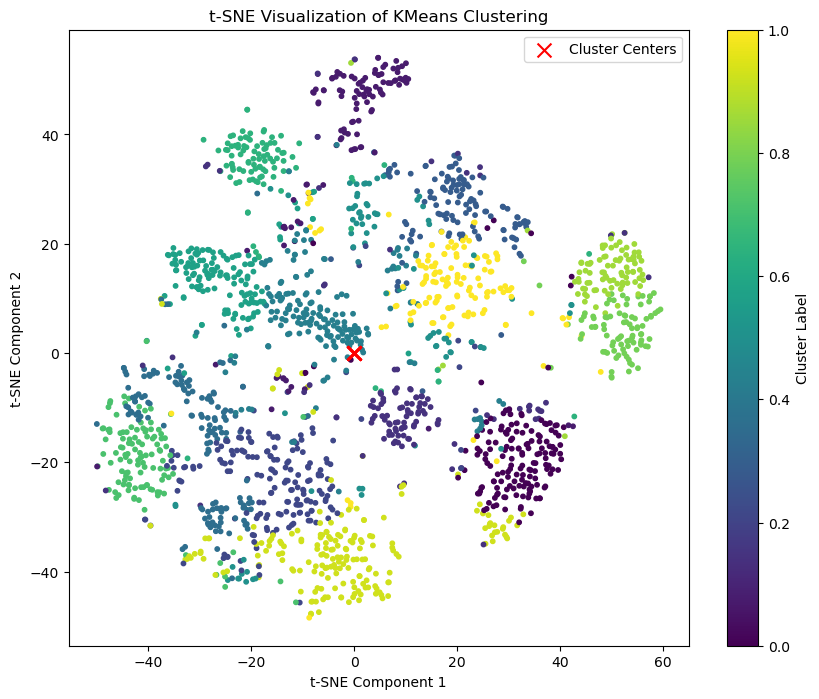

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

# 获取聚类标签和聚类中心
labels = kmeans.labels_[:2000]
centers = kmeans.cluster_centers_[:2000]

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.vstack(vectors[:2000]))

# 可视化聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.title('t-SNE Visualization of KMeans Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()


#### 2、K为25时

In [111]:
# 减少整体数据量 弄个k=25的
vectors, labels = [], []
for vector in train_data:
    a, b = convert(vector)
    vectors.append(a)
    labels.append(b)

In [101]:
# 对比的结果
k = 25
initial_centers = kmeans_pp_init(vectors[:2000], k)

In [106]:
# 初始化并拟合 KMeans 模型，设置终止条件
kmeans = KMeans(n_clusters=25, controids=initial_centers)
kmeans.fit(np.vstack(vectors[:2000]))

  2%|▏         | 2/100 [00:00<00:14,  6.58it/s]

整体欧氏距离为74187.42135169807
整体欧氏距离为68931.66442575259


  4%|▍         | 4/100 [00:00<00:11,  8.29it/s]

整体欧氏距离为67097.62591023529
整体欧氏距离为66244.19584330317


  6%|▌         | 6/100 [00:00<00:10,  9.09it/s]

整体欧氏距离为65760.081053047
整体欧氏距离为65491.418662053795


  8%|▊         | 8/100 [00:00<00:10,  8.83it/s]

整体欧氏距离为65316.313340410255
整体欧氏距离为65188.06766462743


 10%|█         | 10/100 [00:01<00:10,  8.38it/s]

整体欧氏距离为65091.322654132804
整体欧氏距离为65027.24675857912


 12%|█▏        | 12/100 [00:01<00:09,  8.90it/s]

整体欧氏距离为64986.584623776915
整体欧氏距离为64956.417631008924


 14%|█▍        | 14/100 [00:01<00:10,  8.31it/s]

整体欧氏距离为64938.77246942704
整体欧氏距离为64919.56033499564


 16%|█▌        | 16/100 [00:01<00:09,  8.79it/s]

整体欧氏距离为64899.61132034168
整体欧氏距离为64889.424796658146


 18%|█▊        | 18/100 [00:02<00:11,  7.31it/s]

整体欧氏距离为64880.943473939114
整体欧氏距离为64878.80124239912


 18%|█▊        | 18/100 [00:02<00:10,  7.67it/s]


In [107]:
from collections import Counter


# 每个聚类中的样本统计标签
cluster_labels = [[] for _ in range(25)]
for i, label in enumerate(kmeans.labels_):  # 假设你的聚类结果存储在kmeans.labels_中
    cluster_labels[label].append(labels[i])

# 多数投票确定标签
final_cluster_labels = []
for labels in cluster_labels:
    if len(labels) > 0:
        most_common_label = Counter(labels).most_common(1)[0][0]
        final_cluster_labels.append(most_common_label)
    else:
        # 处理没有样本的聚类
        final_cluster_labels.append(None)

# 设置阈值
threshold = 5  
for i, labels in enumerate(cluster_labels):
    if len(labels) > 0:
        counts = Counter(labels)
        if counts.most_common(1)[0][1] >= threshold:
            final_cluster_labels[i] = counts.most_common(1)[0][0]

# 最终的聚类标签
print(final_cluster_labels)

[0, 5, 4, 6, 2, 9, 3, 6, 0, 4, 7, 8, 2, 3, 7, 6, 0, 3, 9, 3, 1, 8, 9, 1, 9]


In [108]:
predict_labels = [final_cluster_labels[i] for i in kmeans.labels_]

Accuracy: 0.709
Confusion Matrix:
[[166   0   2  11   0   5   5   0   2   0]
 [  0 217   0   1   0   0   1   0   1   0]
 [  0  18 128  13  11   3  20   3   2   0]
 [  2   3   1 170   0   2   3   1   5   4]
 [  0   7   1   2  87   2  13   0   0 102]
 [  3   1   1  86   0  59   2   0  18  10]
 [  4   4   1   1   0   0 189   0   0   1]
 [  0   9   0   0   3   5   3 131   0  73]
 [  0   4   1  42   0   2   3   0 110  10]
 [  1   1   0   7  34   0   2   3   1 161]]


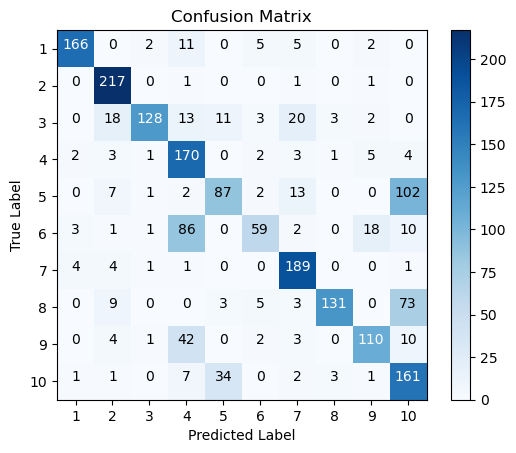

Precision: 0.759552288810515
Recall: 0.7062333399304774


In [112]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
labels = labels[:2000]

# 计算准确率
accuracy = accuracy_score(labels, predict_labels)
print("Accuracy:", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(labels, predict_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, range(1, len(conf_matrix) + 1))
plt.yticks(tick_marks, range(1, len(conf_matrix) + 1))

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")

plt.show()

# 计算精确率和召回率
precision = precision_score(labels, predict_labels, average='macro')
recall = recall_score(labels, predict_labels, average='macro')
print("Precision:", precision)
print("Recall:", recall)


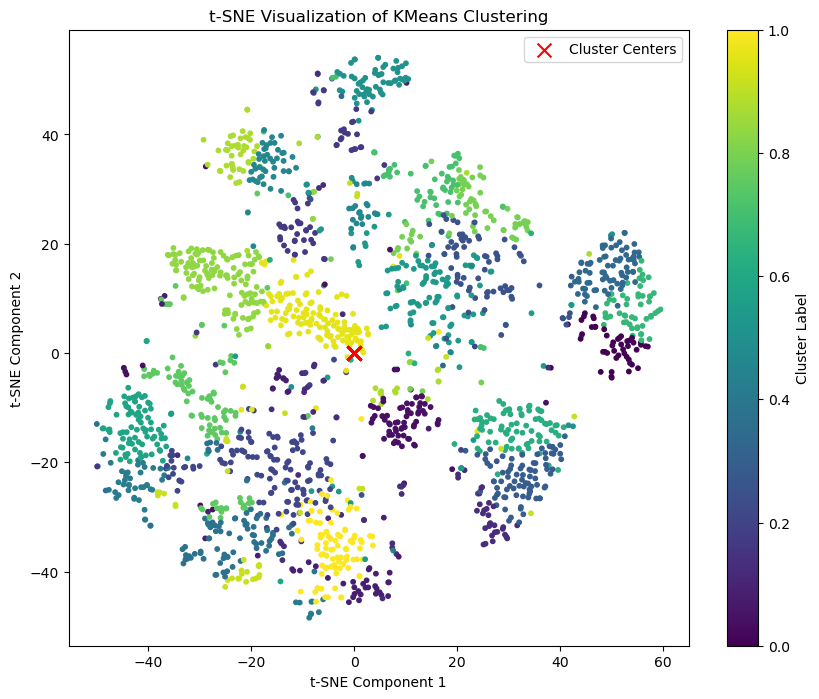

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

# 获取聚类标签和聚类中心
labels = kmeans.labels_[:2000]
centers = kmeans.cluster_centers_[:2000]

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.vstack(vectors[:2000]))

# 可视化聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.title('t-SNE Visualization of KMeans Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()


## （二）不同初始化中心位置的影响

In [162]:
num_vectors = 15
vector_dimension = 784
initial_centers = np.random.randint(0, 15, size=(num_vectors, vector_dimension))


In [164]:
vectors, labels = [], []
for vector in train_data:
    a, b = convert(vector)
    vectors.append(a)
    labels.append(b)
    

In [165]:
# 初始化并拟合 KMeans 模型，设置终止条件
kmeans = KMeans(n_clusters=15, controids=initial_centers)
kmeans.fit(np.vstack(vectors[:2000]))

  1%|          | 1/100 [00:00<00:17,  5.57it/s]

整体欧氏距离为104167.94429658592


Accuracy: 0.6655
Confusion Matrix:
[[165   1   1  10   0   9   3   0   2   0]
 [  0 214   0   1   0   1   0   0   4   0]
 [  0  26 138  10   4  11   0   5   3   1]
 [  2  13   1 153   4   6   1   2   8   1]
 [  0  14   2   0 125   9   2   0   0  62]
 [  6   3   1  81   8  68   4   0   7   2]
 [  4  17  35   1   1  12 130   0   0   0]
 [  0  23   1   1  35  12   0 140   0  12]
 [  0   9   1  42   5   5   1   0 104   5]
 [  2   4   0   9  94   4   1   1   1  94]]


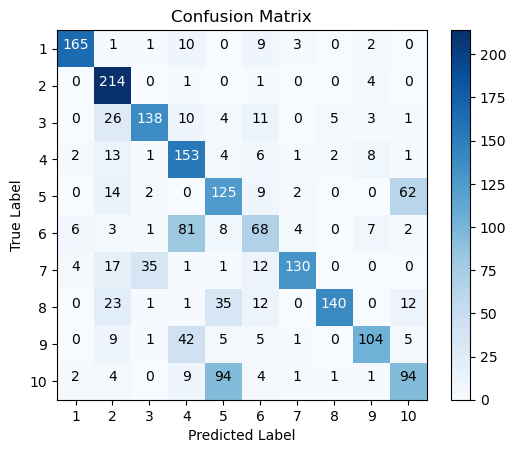

Precision: 0.699366426617346
Recall: 0.6623778573385789


In [166]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

labels = labels[:2000]
# 计算准确率
accuracy = accuracy_score(labels, predict_labels)
print("Accuracy:", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(labels, predict_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, range(1, len(conf_matrix) + 1))
plt.yticks(tick_marks, range(1, len(conf_matrix) + 1))

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")

plt.show()

# 计算精确率和召回率
precision = precision_score(labels, predict_labels, average='macro')
recall = recall_score(labels, predict_labels, average='macro')
print("Precision:", precision)
print("Recall:", recall)


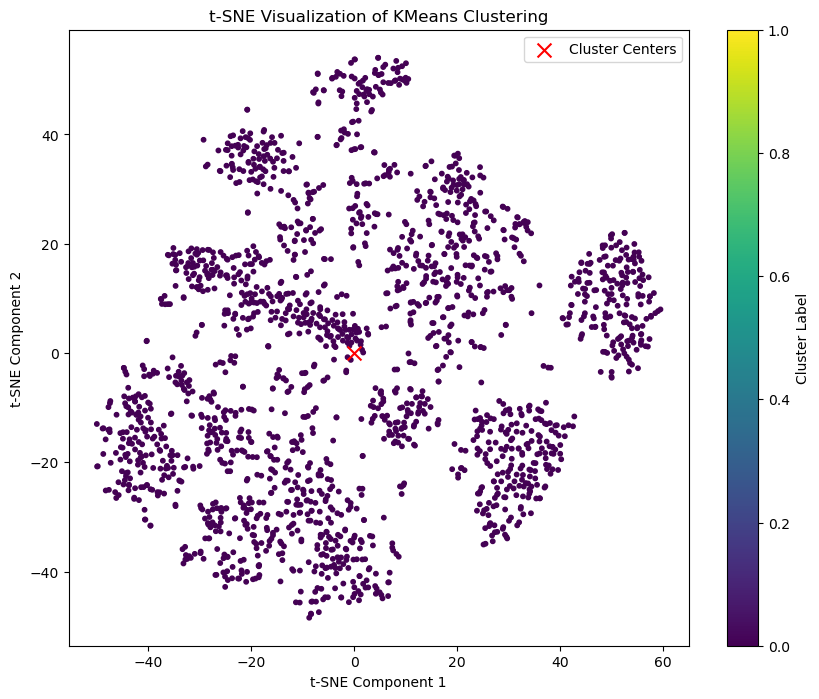

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

# 获取聚类标签和聚类中心
labels = kmeans.labels_[:2000]
centers = kmeans.cluster_centers_[:2000]

# 使用 t-SNE 进行降维

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.vstack(vectors[:2000]))

# 可视化聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.title('t-SNE Visualization of KMeans Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()


## （三）不同样本距离衡量方式的影响

In [137]:
# 欧氏距离和马氏距离
from tqdm import tqdm

class KMeans:
    def __init__(self, n_clusters, controids, max_iter=100, tol=1e-4):
        # 初始化方法，用于设定 KMeans 类的参数
        self.n_clusters = n_clusters  # 簇的数量
    
        self.max_iter = max_iter  # 最大迭代次数
        self.tol = tol  # 收敛容忍度
        self.controids = controids
        self.distances = []

    def _compute_inertia(self, X, centroids, labels):
        inertia = 0
        for centroid_index, centroid in enumerate(centroids):
            # 找到属于该聚类的数据点
            cluster_points = X[labels == centroid_index]
            # 计算马氏距离
            if len(cluster_points) > 0:
                cluster_inertia = np.sum(np.linalg.norm(cluster_points - centroid, ord=2, axis=1))
                inertia += cluster_inertia
        return inertia

    def fit(self, X):
        # 拟合方法，用于训练 KMeans 模型
        # 初始化之心
        centroids = np.stack(self.controids)
        
        # 初始化迭代过程的变量
        prev_centroids = None  
        prev_labels = None 
        prev_inertia = None 
        no_change_iters = 0  
        
        for _ in tqdm(range(self.max_iter)):  # 在这里添加 tqdm
            # 将每个数据点分配到最近的质心
            labels = self._assign_labels(X, centroids)
            
            # 更新质心
            centroids = self._update_centroids(X, labels)
            
            # 计算整体距离（数据点到质心的平方距离之和）
            inertia = self._compute_inertia(X, centroids, labels)
            
            # 检查收敛条件
            if (prev_inertia is not None and abs(inertia - prev_inertia) < self.tol) or no_change_iters >= 5:
                break  # 如果整体距离变化不显著或连续5次没有变化，则停止迭代
            
            if prev_centroids is not None and np.allclose(centroids, prev_centroids, atol=self.tol):
                no_change_iters += 1
            else:
                no_change_iters = 0
            
            # 报告这一轮的结果
            print(f"整体马氏距离为{inertia}")

            # 更新下一轮迭代的先前值
            prev_centroids = centroids.copy()
            prev_labels = labels.copy()
            prev_inertia = inertia
        
        # 将结果存储在对象属性中
        self.labels_ = prev_labels  # 簇标签
        self.cluster_centers_ = prev_centroids  # 质心
        self.inertia_ = prev_inertia  # 整体距离
        self.distances.append(prev_inertia)
        return self  # 返回自身
    
    def _assign_labels(self, X, centroids):
        # 辅助方法：将数据点分配到最近的质心
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X, labels):
        # 辅助方法：更新质心位置
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            centroids[i] = np.mean(X[labels == i], axis=0)
        return centroids
        


In [138]:
# 初始化并拟合 KMeans 模型，设置终止条件
kmeans = KMeans(n_clusters=15, controids=initial_centers)
kmeans.fit(np.vstack(vectors[:2000]))

  3%|▎         | 3/100 [00:00<00:10,  9.37it/s]

整体马氏距离为12607.955397524078
整体马氏距离为12163.619631290649
整体马氏距离为12006.157237246698


  5%|▌         | 5/100 [00:00<00:08, 11.02it/s]

整体马氏距离为11943.639747609042
整体马氏距离为11908.30865632791
整体马氏距离为11883.779813871457


  9%|▉         | 9/100 [00:00<00:07, 12.85it/s]

整体马氏距离为11859.824965270276
整体马氏距离为11835.205416209672
整体马氏距离为11812.740053441024


 13%|█▎        | 13/100 [00:01<00:06, 14.14it/s]

整体马氏距离为11797.816053676452
整体马氏距离为11783.736971717806
整体马氏距离为11771.317904266365
整体马氏距离为11760.40783608199


 15%|█▌        | 15/100 [00:01<00:05, 14.32it/s]

整体马氏距离为11748.723463619513
整体马氏距离为11735.752969134464
整体马氏距离为11718.732907140824


 19%|█▉        | 19/100 [00:01<00:06, 13.41it/s]

整体马氏距离为11703.141129442873
整体马氏距离为11693.263220143492
整体马氏距离为11687.435743437327


 21%|██        | 21/100 [00:01<00:05, 13.68it/s]

整体马氏距离为11683.09620007819
整体马氏距离为11680.477212598655
整体马氏距离为11678.380573951366


 25%|██▌       | 25/100 [00:01<00:05, 13.66it/s]

整体马氏距离为11676.826643754404
整体马氏距离为11675.49686811096
整体马氏距离为11673.703099940372


 27%|██▋       | 27/100 [00:02<00:05, 13.98it/s]

整体马氏距离为11673.25018003752
整体马氏距离为11672.790464223655
整体马氏距离为11672.30793681396


 31%|███       | 31/100 [00:02<00:04, 14.32it/s]

整体马氏距离为11671.706416221894
整体马氏距离为11670.938710100498
整体马氏距离为11670.546251721244


 33%|███▎      | 33/100 [00:02<00:05, 12.93it/s]

整体马氏距离为11670.352748259931
整体马氏距离为11670.262061841675


In [139]:
from collections import Counter


# 每个聚类中的样本统计标签
cluster_labels = [[] for _ in range(15)]
for i, label in enumerate(kmeans.labels_):  # 假设你的聚类结果存储在kmeans.labels_中
    cluster_labels[label].append(labels[i])

# 多数投票确定标签
final_cluster_labels = []
for labels in cluster_labels:
    if len(labels) > 0:
        most_common_label = Counter(labels).most_common(1)[0][0]
        final_cluster_labels.append(most_common_label)
    else:
        # 处理没有样本的聚类
        final_cluster_labels.append(None)

# 设置阈值
threshold = 5  
for i, labels in enumerate(cluster_labels):
    if len(labels) > 0:
        counts = Counter(labels)
        if counts.most_common(1)[0][1] >= threshold:
            final_cluster_labels[i] = counts.most_common(1)[0][0]

# 最终的聚类标签
print(final_cluster_labels)

[2, 1, 1, 5, 0, 3, 8, 2, 9, 7, 4, 3, 4, 6, 0]


In [140]:
predict_labels = [final_cluster_labels[i] for i in kmeans.labels_]

Accuracy: 0.6655
Confusion Matrix:
[[165   1   1  10   0   9   3   0   2   0]
 [  0 214   0   1   0   1   0   0   4   0]
 [  0  26 138  10   4  11   0   5   3   1]
 [  2  13   1 153   4   6   1   2   8   1]
 [  0  14   2   0 125   9   2   0   0  62]
 [  6   3   1  81   8  68   4   0   7   2]
 [  4  17  35   1   1  12 130   0   0   0]
 [  0  23   1   1  35  12   0 140   0  12]
 [  0   9   1  42   5   5   1   0 104   5]
 [  2   4   0   9  94   4   1   1   1  94]]


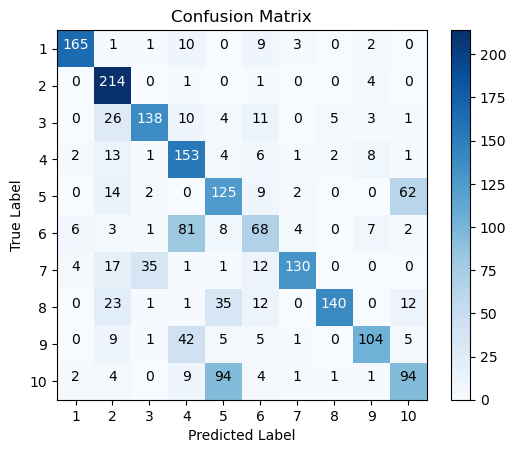

Precision: 0.699366426617346
Recall: 0.6623778573385789


In [144]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
labels = labels[:2000]

# 计算准确率
accuracy = accuracy_score(labels, predict_labels)
print("Accuracy:", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(labels, predict_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, range(1, len(conf_matrix) + 1))
plt.yticks(tick_marks, range(1, len(conf_matrix) + 1))

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")

plt.show()

# 计算精确率和召回率
precision = precision_score(labels, predict_labels, average='macro')
recall = recall_score(labels, predict_labels, average='macro')
print("Precision:", precision)
print("Recall:", recall)


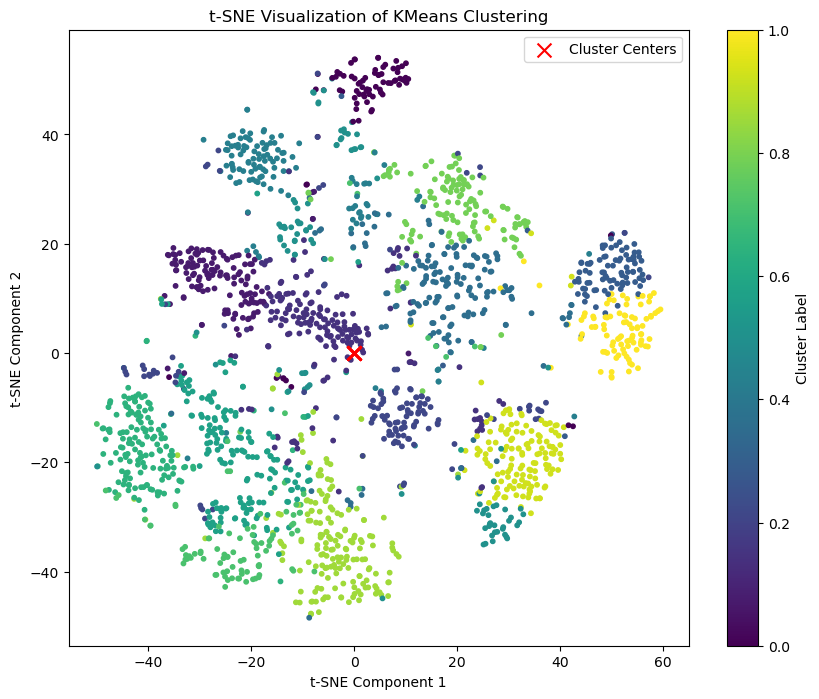

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

# 获取聚类标签和聚类中心
labels = kmeans.labels_[:2000]
centers = kmeans.cluster_centers_[:2000]

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.vstack(vectors[:2000]))

# 可视化聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.title('t-SNE Visualization of KMeans Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()
